# Experiment 2
This is the second experiment for the paper entitled "DAE: Towards Enpowering Denoising in Side-Channel Analysis".

The DPAv2 dataset can be generated from `DPAv2_generate.ipynb`.

In [ ]:
# load models
%matplotlib inline
import numpy as np
np.random.seed(1337)  # for reproducibility
import math
from keras.layers import *
from keras.models import Model
from keras import backend as K
import scipy.io as scio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.callbacks import *
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras import regularizers
from keras import losses
import matplotlib.pyplot as plt
import sklearn.preprocessing
from utils import *

import os
from keras.utils import multi_gpu_model
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

## adjust this according to your configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

# Extract Traces

85000 traces for profiling, 15000 traces for attack.

In [17]:
dataFolder = './DPAv2/'
dataRawFile = dataFolder+'Traces/raw_trc_dpav2_s8_id_mean.mat'
x_noised = scio.loadmat(dataRawFile)['noisedtrc'].astype('float32')
x = scio.loadmat(dataRawFile)['cleantrc_id'].astype('float32')
y = scio.loadmat(dataRawFile)['v_id']

########################
experiment_id = '2'
########################

x = x.reshape(-1, x.shape[1])
x_noised = x_noised.reshape(-1, x_noised.shape[1])



# Splitting for Training and testing 
# 992/16=62 for the convenience of downsampling and upsampling in conv_skip_dae, clip 8 points,
x_noised_train, x_noised_test, x_train, x_test= train_test_split(x_noised[:,:-8], x[:,:-8], test_size=0.15, random_state=22)
y_train, y_test = train_test_split(y, test_size=0.15, random_state=22)

#数据预处理
min_max_scaler_1 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_train = min_max_scaler_1.fit_transform(x_train)
x_test = min_max_scaler_1.transform(x_test)

min_max_scaler_2 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_noised_train = min_max_scaler_2.fit_transform(x_noised_train)
x_noised_test = min_max_scaler_2.transform(x_noised_test)


# data plot

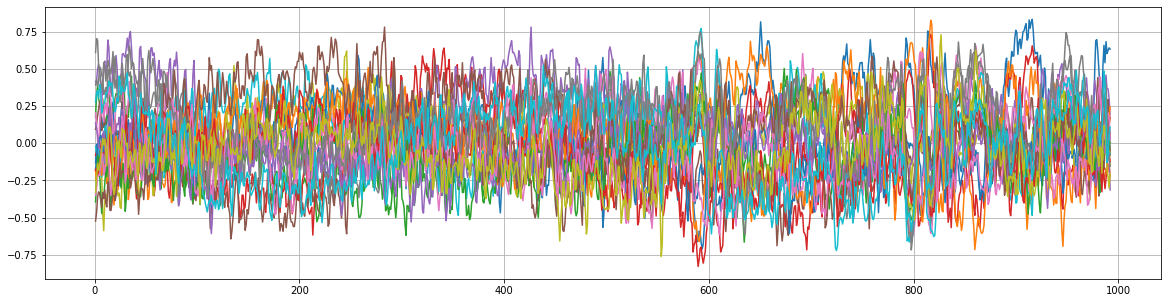

In [4]:
import ipywidgets
def f(m):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(np.linspace(m[0],m[1],m[1]-m[0]),x_noised_train[np.where(y_train[:,0]==2)[0][:20],m[0]:m[1]].T,label='noisedtrc')
    plt.show()
w = ipywidgets.interact(f,m=ipywidgets.IntRangeSlider(description='Zoom',value=[0,992],min=1,max=992))

## Build CDAE and Train

In [18]:
# Convolutional denoising autoencoder with downsampling and upsampling
def conv_skip_dae(loss='mse',optimizer='adam',MultiGPU=False):
    
    input_dim = x_train.shape[1]
    # this is our input placeholder  
    input_img = Input(shape=(input_dim,1))  
    # Encoder 
    encoded1 = Conv1D(16, 11, padding='same', name='Conv1')(input_img)
    encoded1 = LeakyReLU()(encoded1)
    
    encoded2 = MaxPooling1D(2, padding='same', name='DownSampling1')(encoded1)
    encoded2 = Conv1D(32, 11, padding='same')(encoded2)
    encoded2 = LeakyReLU()(encoded2)
    
    encoded3 = MaxPooling1D(2, padding='same')(encoded2)
    encoded3 = Conv1D(64, 11, padding='same')(encoded3)
    encoded3 = LeakyReLU()(encoded3)
    
    encoded4 = MaxPooling1D(2, padding='same')(encoded3)
    encoded4 = Conv1D(128, 11, padding='same', name='Conv2')(encoded4)
    encoded4 = LeakyReLU()(encoded4)
    encoder_output = MaxPooling1D(2, padding='same', name='Encoded')(encoded4)
    # Decoder  
    decoded5 = Conv1D(128, 11, padding='same',name='Conv3')(encoder_output)
    decoded5 = LeakyReLU()(decoded5)
    decoded5 = UpSampling1D(2, name = 'UpSampling3')(decoded5)
    
    decoded6 = add([decoded5,encoded4])
    
    decoded6 = Conv1D(64, 11, padding='same')(decoded6)
    decoded6 = LeakyReLU()(decoded6)
    decoded6 = UpSampling1D(2)(decoded6)
    
    decoded7 = add([decoded6,encoded3])
    
    decoded7 = Conv1D(32, 11, padding='same')(decoded7)
    decoded7 = LeakyReLU()(decoded7)
    decoded7 = UpSampling1D(2)(decoded7)
    
    decoded8 = add([decoded7,encoded2])
    
    decoded8 = Conv1D(16, 11, padding='same',name='Conv4')(decoded8)
    decoded8 = LeakyReLU()(decoded8)
    decoded8 = UpSampling1D(2, name = 'UpSampling4')(decoded8)
    
    decoded9 = add([decoded8,encoded1])

    
    decoded9 = Conv1D(1, 11, activation='tanh', padding='same',name='Conv5')(decoded9)
    # Build model 
    encoder = Model(inputs=input_img, outputs=encoder_output)   
    autoencoder = Model(inputs=input_img, outputs=decoded9)
    print(autoencoder.summary())
    
    if MultiGPU == False:
        autoencoder.compile(loss = loss, optimizer = optimizer)
    else:
        autoencoder = multi_gpu_model(autoencoder, gpus=2)
        autoencoder.compile(loss = loss, optimizer = optimizer) 
        
    return autoencoder, encoder


# Training high level function
def train_denoising_model(model, x_noised_train, x_train, x_noised_test, x_test, callbacks=[], epochs=1000, batch_size=256):
    input_layer_shape = model.get_layer(index=0).input_shape
    if len(input_layer_shape) == 2:
        Reshaped_x_noised_train = x_noised_train
        Reshaped_x_train = x_train
        Reshaped_x_noised_test = x_noised_test
        Reshaped_x_test = x_test
    elif len(input_layer_shape) == 3:
        Reshaped_x_noised_train = x_noised_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        Reshaped_x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        Reshaped_x_noised_test = x_noised_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        Reshaped_x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
        
    history = model.fit(Reshaped_x_noised_train, Reshaped_x_train, epochs=epochs, batch_size=batch_size, 
                        validation_split = 0.2143, callbacks=callbacks)
    
    return history



# Set training details
loss = 'mse'
optimizer = Adam(lr=0.0001)
checkpointer = ModelCheckpoint(
						filepath='cdae'+experiment_id+'.h5',
						monitor="val_loss",
						mode="min",
						verbose=1,
						save_best_only=True,
                        save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reducedLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=0.00001, cooldown=5, min_lr=0.000001)
callbacks = [early_stopping,checkpointer,reducedLR]

# Get the autoencoder and encoder
autoencoder, encoder = conv_dae(loss=loss, optimizer=optimizer, MultiGPU = True)


/home/yg/anaconda3/envs/dlsca/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 992, 1)       0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 992, 16)      192         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 992, 16)      0           Conv1[0][0]                      
__________________________________________________________________________________________________
DownSampling1 (MaxPooling1D)    (None, 496, 16)      0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
conv1d_5 (

In [ ]:
# Train the model and save weights
history = train_denoising_model(autoencoder, x_noised_train, x_train, x_noised_test, x_test,
                                callbacks=callbacks, epochs=500, batch_size=256)

In [20]:
autoencoder.load_weights('cdae'+experiment_id+'.h5')
score = autoencoder.evaluate(x_noised_test.reshape(-1,x_noised_test.shape[1],1), x_test.reshape(-1,x_test.shape[1],1))
print('testing score is',score)

# Computing model output
denoised_train = autoencoder.predict(x_noised_train.reshape(-1,x_noised_train.shape[1],1)).reshape(x_noised_train.shape[0],-1)
denoised_test = autoencoder.predict(x_noised_test.reshape(-1,x_noised_test.shape[1],1)).reshape(x_noised_test.shape[0],-1)

15000/15000 [==============================] - 4s 238us/step
testing score is 0.08547602204084397


In [21]:
# Inverse mapminmax
denoised_train = min_max_scaler_1.inverse_transform(denoised_train)
denoised_test = min_max_scaler_1.inverse_transform(denoised_test)
x_noised_train = min_max_scaler_2.inverse_transform(x_noised_train)
x_noised_test = min_max_scaler_2.inverse_transform(x_noised_test)

## Training visualizaion

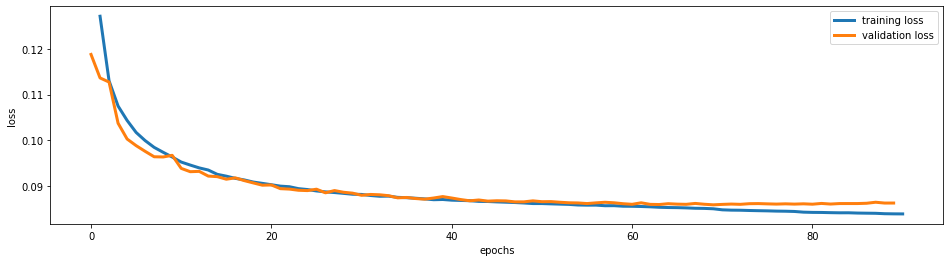

In [22]:
val_loss = history.history['val_loss']
loss = history.history['loss']

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(111)
ax1.plot(history.epoch[1:],loss[1:],val_loss[1:],linewidth=3)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend(['training loss','validation loss'])
plt.show()

## Load Preprocessed SSA Traces

In [ ]:
import h5py
in_file = './Traces/SSA_s8_id.mat'
x_noised_ssa =  scio.loadmat(in_file)['trace_ssa2']
x_noised_train_ssa, x_noised_test_ssa = train_test_split(x_noised_ssa[:,8:], test_size=0.15, random_state=22)

## paper plot

In [24]:
def cal_HMweight(n):
    n = (n & 0x55555555) + ((n >> 1) & 0x55555555)
    n = (n & 0x33333333) + ((n >> 2) & 0x33333333)
    n = (n & 0x0F0F0F0F) + ((n >> 4) & 0x0F0F0F0F)
    n = (n & 0x00FF00FF) + ((n >> 8) & 0x00FF00FF)
    n = (n & 0x0000FFFF) + ((n >> 16) & 0x0000FFFF)
    return n

midval_id = y_train
midval_hw = cal_HMweight(y_train)

tk_corr = corr(x_noised_train, midval_id[:, 0:1])  ## Midvalue is in the first colume
poi_id = np.argsort(-np.abs(tk_corr.T)).T
tk_corr = corr(x_noised_train, midval_hw[:, 0:1])
poi_hw = np.argsort(-np.abs(tk_corr.T)).T

trc_index_hw = []
for i in range(9):
    trc_index_hw.append(np.where(midval_hw[:,0]==i)[0])
    
trc_index_id = []
for i in range(256):
    trc_index_id.append(np.where(midval_id[:,0]==i)[0])

### KDE Plot (Original Traces)
This is the Kernel Density Estimation (KDE) of the point of interest.

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


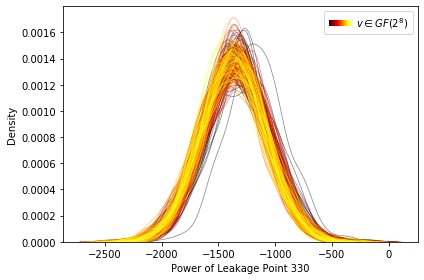

In [107]:
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import norm
custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(x_noised_train[trc_index_id[i],poi_id[1]], kde_kws={"color": plt.cm.hot(i-50),'alpha':0.5,"lw": 0.7},hist=False)
ax1.legend(custom_lines, [r'$v \in GF(2^8)$'])
plt.xlabel('Power of Leakage Point '+str(poi_id[1][0]))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.770, 0.895, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/dpav2_hist_1.pdf')

### KDE Plot (CDAE Preprocessed Traces)

/home/yg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


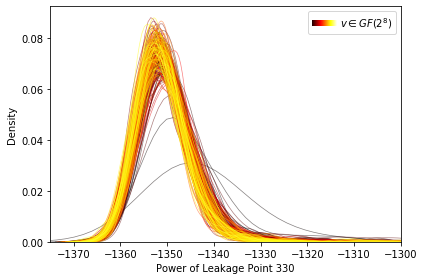

In [108]:
from matplotlib.lines import Line2D
from scipy.stats import norm
custom_lines = [Line2D([0], [0], color=plt.cm.hot(255), lw=4)]
fig, ax1 = plt.subplots()
for i in range(256):
    sns.distplot(denoised_train[trc_index_id[i],poi_id[1]],kde_kws={"color": plt.cm.hot(i-50),'alpha':0.5,"lw": 0.7},hist=False)
ax1.legend(custom_lines, [r'$v \in GF(2^8)$'],loc=1)
plt.xlabel('Power of Leakage Point '+str(poi_id[1][0]))
plt.xlim((-1375,-1300))
plt.ylabel('Density')
# plt.suptitle('ID joint distribution in top 9 PoI',fontsize=10)

import matplotlib as mpl
# ax2 = fig.add_axes([0.623, 0.816, 0.053, 0.015])
ax2 = fig.add_axes([0.730, 0.895, 0.06, 0.02])
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=256)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.outline.set_visible(False)
plt.tight_layout()
plt.savefig('./fig/dpav2_hist_2.pdf')

### Signal-Noise Ratio (SNR) and Pearson Correlation Coefficient (PCC) for Original Traces and CDAE Prepocessed Traces

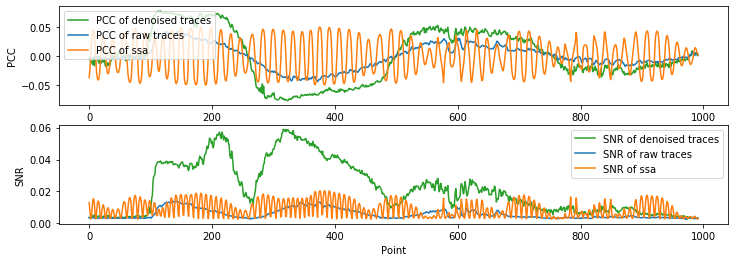

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(corr(denoised_train,y_train[:,0]),color=list(plt.rcParams['axes.prop_cycle'])[2]['color'],label='PCC of denoised traces')
plt.plot(corr(x_noised_train,y_train[:,0]),color=list(plt.rcParams['axes.prop_cycle'])[0]['color'],label='PCC of raw traces')
plt.plot(corr(x_noised_train_ssa,y_train[:,0]),color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],label='PCC of ssa')
plt.ylabel('PCC')
plt.legend(loc=2)
plt.subplot(212)
# plt.axvline(276,color=list(plt.rcParams['axes.prop_cycle'])[3]['color'],linestyle='--',label='Leakage point 276')
plt.plot(snr(denoised_train,y_train[:,0:1]),color=list(plt.rcParams['axes.prop_cycle'])[2]['color'],label='SNR of denoised traces')
plt.plot(snr(x_noised_train,y_train[:,0:1]),color=list(plt.rcParams['axes.prop_cycle'])[0]['color'],label='SNR of raw traces')
plt.plot(snr(x_noised_train_ssa,y_train[:,0:1]),color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],label='SNR of ssa')
plt.xlabel('Point')
plt.ylabel('SNR')
plt.legend()
# plt.savefig('./gpu_denoise1.eps',dpi=800)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


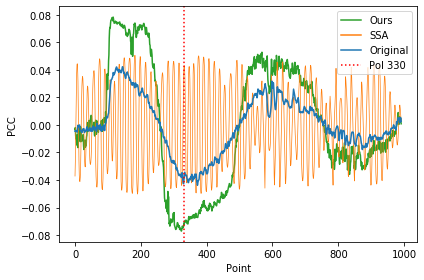

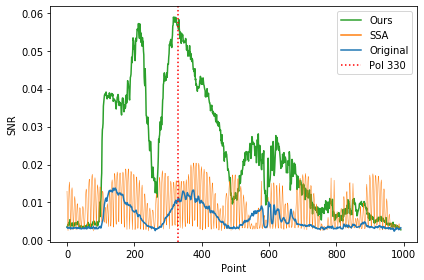

In [59]:
custom_lines = [Line2D([0], [0], color=list(plt.rcParams['axes.prop_cycle'])[2]['color'], lw=1.5),
                Line2D([0], [0], color=list(plt.rcParams['axes.prop_cycle'])[1]['color'], lw=1.5),
                Line2D([0], [0], color=list(plt.rcParams['axes.prop_cycle'])[0]['color'], lw=1.5),
                Line2D([0], [0], color='r', lw=1.5,linestyle=':')]


plt.figure()
plt.plot(corr(denoised_train,y_train[:,0]),color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])
plt.plot(corr(x_noised_train_ssa,y_train[:,0:1].reshape(-1,1)),color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],linewidth=0.7)
plt.plot(corr(x_noised_train,y_train[:,0]),color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
plt.axvline(poi_id[1],color='r',linestyle=':',label='PoI '+str(poi_id[1][0]))
plt.xlabel('Point')
plt.ylabel('PCC')
plt.legend(custom_lines, ['Ours', 'SSA', 'Original','PoI '+str(poi_id[1][0])])
plt.tight_layout()
plt.savefig('./fig/dpav2_pcc.eps')

plt.figure()
plt.plot(snr(denoised_train,y_train[:,0:1]),color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])
plt.plot(snr(x_noised_train_ssa,y_train[:,0:1].reshape(-1,1)),color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],linewidth=0.5)
plt.plot(snr(x_noised_train,y_train[:,0:1]),color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
plt.axvline(poi_id[1],color='r',linestyle=':',label='PoI '+str(poi_id[1][0]))
plt.xlabel('Point')
plt.ylabel('SNR')
plt.legend(custom_lines, ['Ours', 'SSA', 'Original','PoI '+str(poi_id[1][0])])
plt.tight_layout()
plt.savefig('./fig/dpav2_snr.eps')

In [30]:
print('pcc: ours,ssa,ori',np.abs(corr(denoised_train,y_train[:,0])).max(),np.abs(corr(x_noised_train_ssa,y_train[:,0:1])).max(),np.abs(corr(x_noised_train,y_train[:,0])).max())
print('snr: ours,ssa,ori',np.abs(snr(denoised_train,y_train[:,0:1])).max(),np.abs(snr(x_noised_train_ssa,y_train[:,0:1])).max(),np.abs(snr(x_noised_train,y_train[:,0:1])).max())


pcc: ours,ssa,ori 0.07840349023330555 0.05065440226914623 0.043857733401948935
snr: ours,ssa,ori 0.05886407 0.020417508756367303 0.013801425


## Template Attack

In [40]:
from TemplateAttacks import *
from PoiSelection import *
from Evaluation import *

### TA pooled

In [41]:
result_pooled = {'raw':[],'dae':[],'ssa':[]}
matrix_type = 'pooled'
start,end,step = 50,3000,50
poi_idx = []
poi_type = 'corr'

def trace_norm(x_train,x_test):
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train,x_test

for poi_num in [5,25,50]:
    # propare the concatenate data
    denoised_train_new,denoised_test_new = PoiSelection(denoised_train, y_train[:,0], denoised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    denoised_train_new,denoised_test_new = trace_norm(denoised_train_new,denoised_test_new)
    x_noised_train_new,x_noised_test_new = PoiSelection(x_noised_train, y_train[:,0], x_noised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    x_noised_train_new,x_noised_test_new = trace_norm(x_noised_train_new,x_noised_test_new)
    x_noised_train_ssa_new,x_noised_test_ssa_new = PoiSelection(x_noised_train_ssa, y_train[:,0], x_noised_test_ssa, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    x_noised_train_ssa_new,x_noised_test_ssa_new = trace_norm(x_noised_train_ssa_new,x_noised_test_ssa_new)
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(x_noised_train_new,y_train[:,0])
    prob_new,y_pred = TA_clf.predict(x_noised_test_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_train_new,y_train[:,0])
    prob_de_new,y_pred = TA_clf.predict(denoised_test_new)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(x_noised_train_ssa_new,y_train[:,0])
    prob_ssa_new,y_pred = TA_clf.predict(x_noised_test_ssa_new)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_pooled['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_pooled['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_pooled['ssa'].append(multi_ge3)

Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
2600 traces to achieve 80% success rate
2400 traces to achieve <1 key rank

1100 traces to achieve 80% success rate
1000 traces to achieve <1 key rank

1500 traces to achieve 80% success rate
1150 traces to achieve <1 key rank
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[###

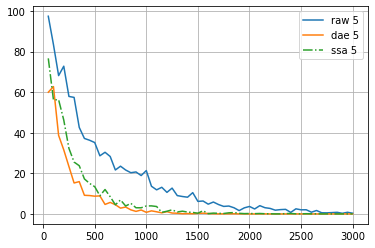

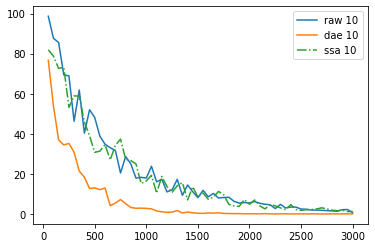

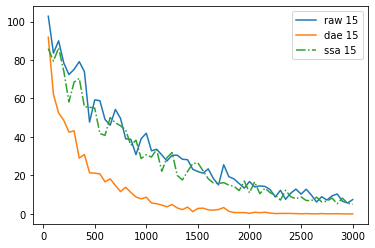

In [42]:
# plt.figure(figsize=(18, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
plt.grid(True)
for i in range(3):
    i=i

    plt.plot(np.arange(start,end+step,step),result_pooled['raw'][i],color = colors[0],linestyle = '-',label='raw '+str(5*(i+1)))

    i = i
    plt.plot(np.arange(start,end+step,step),result_pooled['dae'][i],color = colors[1],linestyle = '-',label='dae '+str(5*(i+1)))

    i=i
    plt.plot(np.arange(start,end+step,step),result_pooled['ssa'][i],color = colors[2],linestyle = '-.',label='ssa '+str(5*(i+1)))

    plt.xscale('linear')
    plt.legend(loc=1)

    plt.show()

### TA covariance

In [53]:
result_cov = {'raw':[],'dae':[],'ssa':[]}
matrix_type = 'covariance'
start,end,step = 50,3000,50
poi_idx = []
poi_type = 'corr'

def trace_norm(x_train,x_test):
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train,x_test

for poi_num in [5,25,50]:
    # propare the concatenate data
    denoised_train_new,denoised_test_new = PoiSelection(denoised_train, y_train[:,0], denoised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
#     denoised_train_new,denoised_test_new = trace_norm(denoised_train_new,denoised_test_new)
    x_noised_train_new,x_noised_test_new = PoiSelection(x_noised_train, y_train[:,0], x_noised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
#     x_noised_train_new,x_noised_test_new = trace_norm(x_noised_train_new,x_noised_test_new)
    x_noised_train_ssa_new,x_noised_test_ssa_new = PoiSelection(x_noised_train_ssa, y_train[:,0], x_noised_test_ssa, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
#     x_noised_train_ssa_new,x_noised_test_ssa_new = trace_norm(x_noised_train_ssa_new,x_noised_test_ssa_new)
    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(x_noised_train_new,y_train[:,0])
    prob_new,y_pred = TA_clf.predict(x_noised_test_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_train_new,y_train[:,0])
    prob_de_new,y_pred = TA_clf.predict(denoised_test_new)

    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(x_noised_train_ssa_new,y_train[:,0])
    prob_ssa_new,y_pred = TA_clf.predict(x_noised_test_ssa_new)
    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_cov['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_cov['dae'].append(multi_ge2)
    multi_sr3,multi_ge3 = prob2score(prob2prob(prob_ssa_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_cov['ssa'].append(multi_ge3)

Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 3000 traces to achieve 80% success rate
more than 3000 traces to achieve <1 bit guessing entropy

more than 3000 traces to achieve 80% success rate
more than 3000 traces to achieve <1 bit guessing entropy

2300 traces to achieve 80% success rate
2000 traces to achieve <1 key rank
Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[#####################################################################################

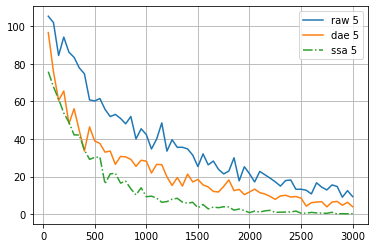

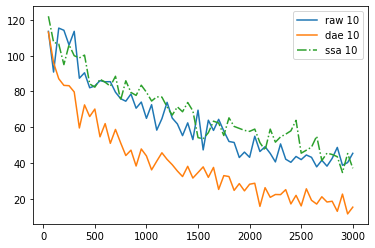

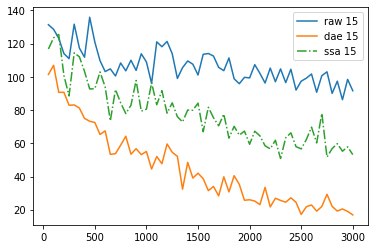

In [54]:
# plt.figure(figsize=(18, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']
plt.grid(True)
for i in range(3):


    plt.plot(np.arange(start,end+step,step),result_cov['raw'][i],color = colors[0],linestyle = '-',label='raw '+str(5*(i+1)))


    plt.plot(np.arange(start,end+step,step),result_cov['dae'][i],color = colors[1],linestyle = '-',label='dae '+str(5*(i+1)))


    plt.plot(np.arange(start,end+step,step),result_cov['ssa'][i],color = colors[2],linestyle = '-.',label='ssa '+str(5*(i+1)))

    plt.xscale('linear')
    plt.legend(loc=1)

    plt.show()

Profiling start
Prob estimating start
[####################################################################################################] 100.0Profiling start
Prob estimating start
[####################################################################################################] 100.0
more than 7000 traces to achieve 80% success rate
7000 traces to achieve <1 key rank

7000 traces to achieve 80% success rate
6000 traces to achieve <1 key rank


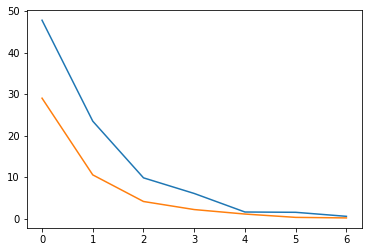

In [106]:
matrix_type = 'covariance'
start,end,step = 1000,7000,1000
poi_idx = []
poi_type = 'corr'

def trace_norm(x_train,x_test):
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train,x_test

for poi_num in [5]:
    # propare the concatenate data
    denoised_train_new,denoised_test_new = PoiSelection(denoised_train, y_train[:,0], denoised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    denoised_train_new,denoised_test_new = trace_norm(denoised_train_new,denoised_test_new)
    x_noised_train_new,x_noised_test_new = PoiSelection(x_noised_train, y_train[:,0], x_noised_test, y_test, poi_type=poi_type, poi_num = poi_num, poi_idx=poi_idx)
    x_noised_train_new,x_noised_test_new = trace_norm(x_noised_train_new,x_noised_test_new)

    
    # profiling & attack    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(x_noised_train_new,y_train[:,0])
    prob_new,y_pred = TA_clf.predict(x_noised_test_new)
    
    TA_clf = TemplateAttacks(matrix_type=matrix_type,n_classes=256)
    TA_clf.fit(denoised_train_new,y_train[:,0])
    prob_de_new,y_pred = TA_clf.predict(denoised_test_new)


    
    # my evaluation
    multi_sr1,multi_ge1 = prob2score(prob2prob(prob_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_cov['raw'].append(multi_ge1)
    multi_sr2,multi_ge2 = prob2score(prob2prob(prob_de_new,y_test[:,0]),start,end,step,eval_time=100,log_sum=False)
    result_cov['dae'].append(multi_ge2)
    
plt.plot(result_cov['raw'][-1])
plt.plot(result_cov['dae'][-1])

### TA reduced

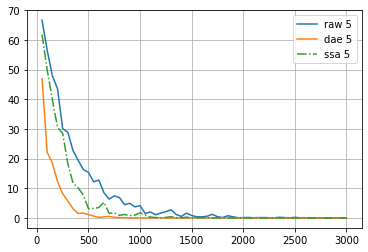

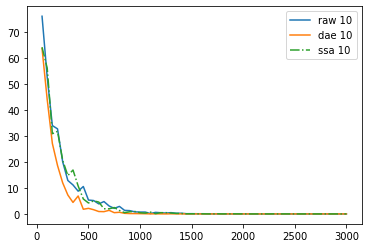

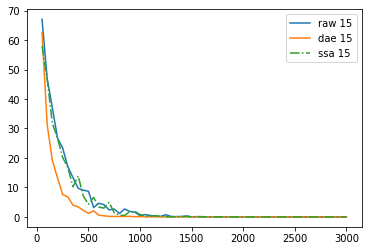

In [47]:
# plt.figure(figsize=(18, 4.8))
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']
plt.grid(True)
for i in range(3):


    plt.plot(np.arange(start,end+step,step),result_reduced['raw'][i],color = colors[0],linestyle = '-',label='raw '+str(5*(i+1)))


    plt.plot(np.arange(start,end+step,step),result_reduced['dae'][i],color = colors[1],linestyle = '-',label='dae '+str(5*(i+1)))


    plt.plot(np.arange(start,end+step,step),result_reduced['ssa'][i],color = colors[2],linestyle = '-.',label='ssa '+str(5*(i+1)))

    plt.xscale('linear')
    plt.legend(loc=1)

    plt.show()

## CPA comparison of origianl/denoised traces preprocessed PCA and LDA 

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(x_noised_train,y_train[:,0])
x_lda_train = lda.transform(x_noised_train)
x_lda_test = lda.transform(x_noised_test)


In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(denoised_train,y_train[:,0])
x_dae_lda_train = lda.transform(denoised_train)
x_dae_lda_test = lda.transform(denoised_test)

In [50]:
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(denoised_train,y_train[:,0])
x_dae_pca_train = pca.transform(denoised_train)
x_dae_pca_test = pca.transform(denoised_test)

pca = PCA()
pca.fit(x_noised_train,y_train[:,0])
x_pca_train = pca.transform(x_noised_train)
x_pca_test = pca.transform(x_noised_test)

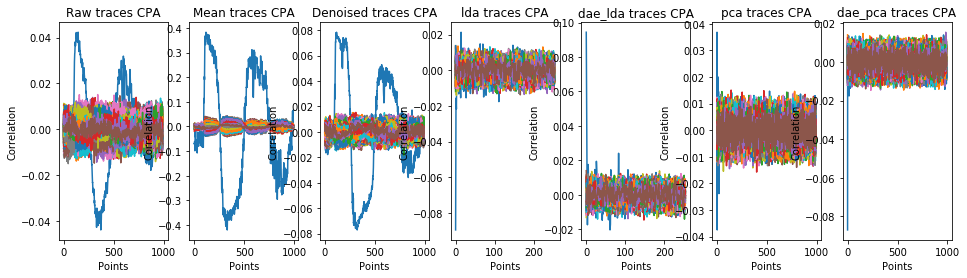

In [51]:
plt.figure(figsize=(16,4))
plt.subplot(171)
plt.plot(corr(x_noised_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('Raw traces CPA')
plt.subplot(172)
plt.plot(corr(x_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('Mean traces CPA')
plt.subplot(173)
plt.plot(corr(denoised_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('Denoised traces CPA')
plt.subplot(174)
plt.plot(corr(x_lda_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('lda traces CPA')
plt.subplot(175)
plt.plot(corr(x_dae_lda_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('dae_lda traces CPA')
plt.subplot(176)
plt.plot(corr(x_pca_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('pca traces CPA')
plt.subplot(177)
plt.plot(corr(x_dae_pca_train,y_train))
plt.xlabel('Points')
plt.ylabel('Correlation')
plt.title('dae_pca traces CPA')
plt.show()


## SNR comparison of origianl/denoised traces preprocessed PCA and LDA 

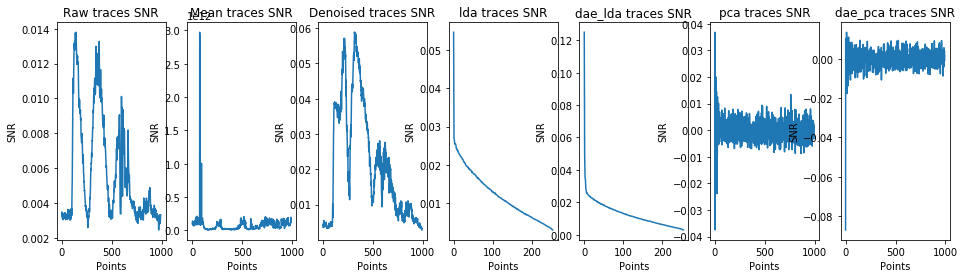

In [98]:
plt.figure(figsize=(16,4))
plt.subplot(171)
plt.plot(snr(x_noised_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('Raw traces SNR')
plt.subplot(172)
plt.plot(snr(x_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('Mean traces SNR')
plt.subplot(173)
plt.plot(snr(denoised_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('Denoised traces SNR')
plt.subplot(174)
plt.plot(snr(x_lda_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('lda traces SNR')
plt.subplot(175)
plt.plot(snr(x_dae_lda_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('dae_lda traces SNR')
plt.subplot(176)
plt.plot(corr(x_pca_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('pca traces SNR')
plt.subplot(177)
plt.plot(corr(x_dae_pca_train,y_train[:,0]))
plt.xlabel('Points')
plt.ylabel('SNR')
plt.title('dae_pca traces SNR')
plt.show()

